In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# flowers-recognition
## Classification with Deep neural network using CNN

In [1]:
#loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import os
import glob as gb
import cv2
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

### Load Data

In [2]:
path = '../input/flowers-recognition/flowers/flowers/'

In [3]:
# print out classes 
for folder in os.listdir(path):
    print(folder)


tulip
daisy
rose
dandelion
sunflower


In [4]:
# this function tacke path and return list of (x , y) , x -> shape , y -> The number of times that shape appears 
# this function load all images
def shapeCount (Gpath):
    size = []
    pathname = str(Gpath+'*/*.jpg')
    imgsDir = gb.glob(pathname= pathname)
    for imgDir in tqdm(imgsDir):
        img = plt.imread(imgDir)
        size.append(img.shape)
    print("number of Imges = ",len(size))
    return pd.Series(size).value_counts()

In [5]:
# print list of (x , y) , x -> shape , y -> The number of times that shape appears 
print (shapeCount(path))

100%|██████████| 4323/4323 [00:32<00:00, 131.08it/s]

number of Imges =  4323
(240, 320, 3)    604
(333, 500, 3)    599
(159, 240, 3)    380
(213, 320, 3)    322
(240, 240, 3)    219
                ... 
(404, 500, 3)      1
(412, 500, 3)      1
(240, 146, 3)      1
(288, 465, 3)      1
(429, 500, 3)      1
Length: 387, dtype: int64


In [6]:
# I_SIZE is ths size of the image after resize it
# calsses is list of different type of flowers

I_SIZE = 200
classes = ['daisy','sunflower','tulip','rose','dandelion']


In [7]:
# this function take all data then shuffle this data
# reArrange this data to X (numpy array of images) , y (numpy array of labels)
def reArangeData(data):
    # shuffle
    import random
    random.shuffle(data)
    
    # get X,Y
    X = []
    y = []
    for img,lable in data:
        X.append(img)
        y.append(lable)
        
    # convert it to npArray
    return np.array(X),np.array(y)

# this function take the images path => load all this images 
# => return X (numpy array of images) , y (numpy array of labels)
def loadImages (path):
    Dlist = []
    for folder in os.listdir(path):
        pathname = str(path +folder+'/*.jpg')
        files = gb.glob(pathname= pathname)
        for file in tqdm(files):
            image = cv2.imread(file ,cv2.IMREAD_COLOR )
            #image = cv2.cvtColor(image , cv2.COLOR_BGR2HSV)
            image_array = cv2.resize(image , (I_SIZE ,I_SIZE))
            Dlist.append( [image_array , classes.index(folder)] )
    print(len(Dlist))
    return reArangeData(Dlist)



In [8]:
# load all data
X , y = loadImages(path)

100%|██████████| 734/734 [00:02<00:00, 271.45it/s]


4323


In [9]:
# normalize all data
X=X/255

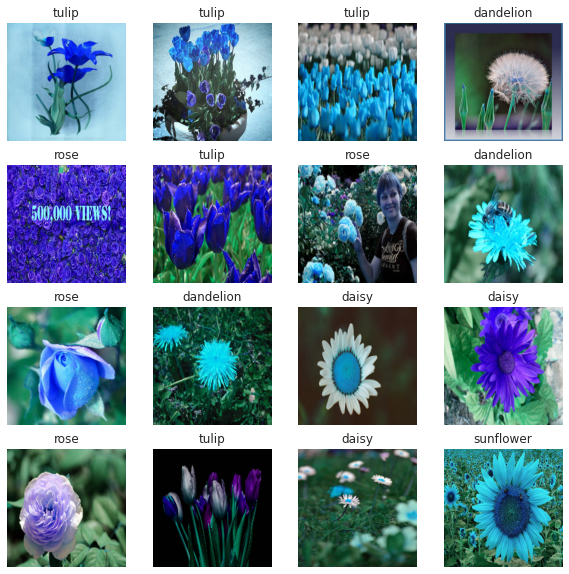

In [10]:
# figure out samples of this data
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(classes[y[i]])

In [11]:
# Divide the data into two groups, the training group at 90 percent and the test group at 10 percent

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [12]:
print('X_train shape is : ',X_train.shape)
print('y_train shape is : ',y_train.shape)
print("---------------------------------------------")
print('X_test shape id : ',X_test.shape)
print('y_test shape id : ',y_test.shape)

X_train shape is :  (3890, 200, 200, 3)
y_train shape is :  (3890,)
---------------------------------------------
X_test shape id :  (433, 200, 200, 3)
y_test shape id :  (433,)


In [ ]:
# X_train = keras.utils.normalize(X_train,axis=1)
# X_test = keras.utils.normalize(X_test,axis=1)
#X_train = X_train/255
#X_test = X_test/255

# Data augmentation 

In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is take photo.

For example, the flower is not centered 
The scale is not the same 
The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. 

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a robust model.

The improvement is important : 
   - Without data augmentation i obtained an accuracy of 62%
   - With data augmentation i achieved 78% of accuracy

In [13]:
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

Using TensorFlow backend.


# create the model

In [14]:
relu = tf.nn.relu
softmax = tf.nn.softmax
input_shape = (I_SIZE , I_SIZE,3)

model = keras.models.Sequential([
    keras.layers.Conv2D(128,kernel_size=(3,3) ,activation=relu , input_shape = input_shape ),
    keras.layers.MaxPool2D(4,4),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Conv2D(512,kernel_size=(3,3),activation=relu),
    
    keras.layers.MaxPool2D(4,4),
    keras.layers.Conv2D(128,kernel_size=(3,3),activation=relu),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Conv2D(64,kernel_size=(3,3),activation=relu),
   
    keras.layers.Flatten(),
    keras.layers.Dense(512,activation=relu),
    keras.layers.Dense(128,activation=relu),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(64,activation=relu),
    keras.layers.Dense(5,activation=softmax)
])

In [15]:
# Setup the way the model learns
# loss function sparse_categorical_crossentropy
# Use Adam optimization algorithm is an extension to stochastic gradient descent with learning rate 0.001

loss = keras.losses.sparse_categorical_crossentropy
adam = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam,
             loss = loss ,
             metrics=['accuracy'])

In [16]:
# print model summary and find the toal number of parameters is 2,938,053 
#(which mean it take time to learn the model)

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 512)       590336    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 128)         589952    
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 128)         0

In [17]:
# train the model and set 70 epochs to to avoid overfitting (we try different number and find it the pest)
# and set the batch size as 32

epochs = 70
batch_size = 32
train_img_gen = datagen.flow(X_train, y_train, batch_size=batch_size)
test_image_gen = datagen.flow(X_test, y_test, batch_size=batch_size)
ThisModel = model.fit_generator(train_img_gen,
                                verbose=1,
                                steps_per_epoch=len(X_train) / 32,
                                validation_data=test_image_gen,
                                epochs=epochs
                               )

Epoch 1/70
122/121 [==============================] - 37s 302ms/step - loss: 1.5542 - accuracy: 0.2797 - val_loss: 1.3104 - val_accuracy: 0.4203
Epoch 2/70
122/121 [==============================] - 37s 301ms/step - loss: 1.2875 - accuracy: 0.4195 - val_loss: 1.1235 - val_accuracy: 0.5104
Epoch 3/70
122/121 [==============================] - 38s 309ms/step - loss: 1.1646 - accuracy: 0.4805 - val_loss: 1.0591 - val_accuracy: 0.4919
Epoch 4/70
122/121 [==============================] - 36s 296ms/step - loss: 1.1141 - accuracy: 0.5075 - val_loss: 1.0515 - val_accuracy: 0.5104
Epoch 5/70
122/121 [==============================] - 37s 304ms/step - loss: 1.0734 - accuracy: 0.5383 - val_loss: 0.9223 - val_accuracy: 0.6513
Epoch 6/70
122/121 [==============================] - 37s 301ms/step - loss: 1.0033 - accuracy: 0.5995 - val_loss: 0.9444 - val_accuracy: 0.6351
Epoch 7/70
122/121 [==============================] - 36s 296ms/step - loss: 0.9404 - accuracy: 0.6334 - val_loss: 0.9015 - val_ac

# Evaluate the model

In [19]:
#evaluation test result
Err,Acc = model.evaluate(X_test,y_test)
print("Err : " , Err)
print("Acc : ", Acc)

14/14 [==============================] - 0s 22ms/step - loss: 0.6778 - accuracy: 0.8083
Err :  0.6777698397636414
Acc :  0.8083140850067139


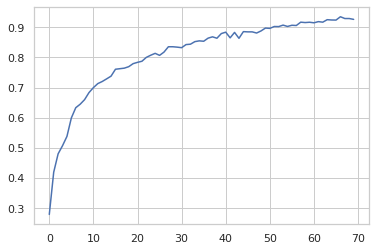

In [21]:
# plot graph for train accuracy evaluation with each epoch
plt.plot(ThisModel.history['accuracy'])

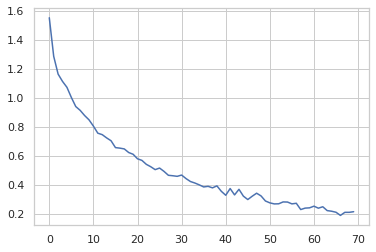

In [22]:
# plot graph for train loss value evaluation with each epoch
plt.plot(ThisModel.history['loss'])

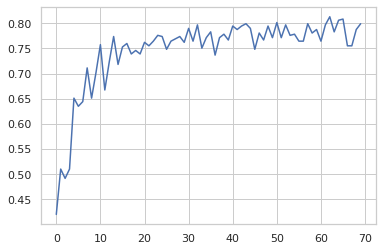

In [23]:
# plot graph for validation accuracy evaluation with each epoch
plt.plot(ThisModel.history['val_accuracy'])

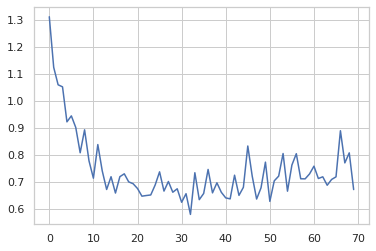

In [24]:
# plot graph for validation loss value evaluation with each epoch
plt.plot(ThisModel.history['val_loss'])

In [28]:
# predict X_test labels
y_predict = model.predict_classes(X_test)
print(y_predict[1] , y_test[1])

2 2


In [29]:
# clasification report 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86        88
           1       0.82      0.90      0.86        68
           2       0.81      0.70      0.75       103
           3       0.65      0.82      0.72        66
           4       0.84      0.85      0.85       108

    accuracy                           0.81       433
   macro avg       0.81      0.81      0.81       433
weighted avg       0.82      0.81      0.81       433



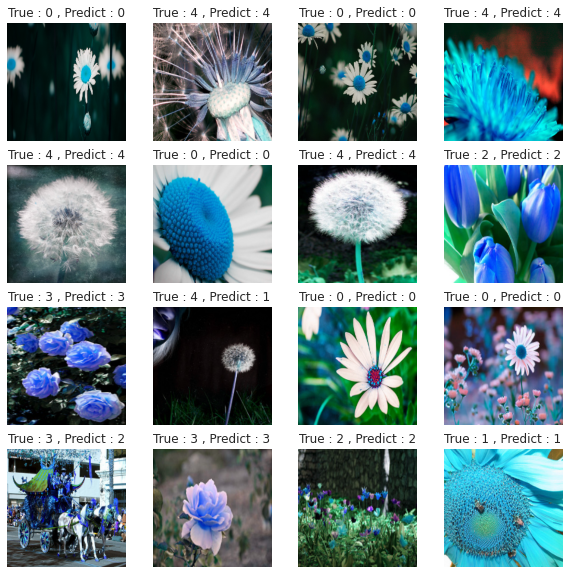

In [39]:
# figure out samples of this data with the true value and predicted ones
plt.figure(figsize=(10,10))
st = 10
for i in range(st,st+16):
    plt.subplot(4,4,i+1-st)
    plt.imshow(X_test[i])
    plt.title("True : {} , Predict : {}".format(y_test[i] , y_predict[i]))
    plt.axis('off')
    #plt.title(classes[y[i]])

In [40]:
model.save('model.h5')